## Background:
One overarching goal of this research project is to determine the feasibility of using the online Yelp platform to collect business listings for retailers of Electronic Nicotine Delivery Systems (ENDS; e.g., vape shops) in Pennsylvania. To this end, I utilized the Yelp API to collect data for all metropolitan and micropolitan census regions in Pennsylvania (which includes some surrounding states). Each API call was set to maximum search radius of 25 miles, targeting a central zipcode within each identified census region (some geographic overlap was present). 

Data have been collected from the Yelp API at roughly 1-month intervals from September 2016 through present. Data are currently stored in CSV files. Monthly API calls were repeated using several distinct search terms such as "vape", "vaping", and "ecig" to maximize sensitivity. 

As a result of overlap in search radii and search terms, each monthly data file contains many redundant listings. As the searches were repeated several times, search results are also redundant among the data files. Also, several results are outside of Pennsylvania, so additional data cleaning is needed to limit the scope of results to unique Pennsylvania ENDS retailers. 

Data were collected as part of an ongoing research project at the University of Pittsburgh's [Center for Research on Media, Technology, and Health](http://mth.pitt.edu/) and are stored in [CRMTH's GitHub "YelpEpi" repository](https://github.com/CRMTH/YelpEpi/). For the purposes of this project, I forked that repo to [my personal GitHub "YelpEpi" repository](https://github.com/colditzjb/YelpEpi/).


### Project goals achieved through this assignment:

* __Loading the data__
 * Load the data from multiple CSV files
 * Troubleshoot data encoding issues


* __Documenting the data__
 * Examine the data characteristics
 * Create a data dictionary to describe variables in each column


* __Cleaning the data__
 * Create a function to find state abbreviations within address fields
 * Create a function to categorize vape shops using Yelp's native categories
 * Create a function to write reduced data columns to a new file
 * Implement these functions across multiple files and create a header row in a new "output" file, which includes all data and includes `timepoint` of data collection
 
 
* __Combining the data__ 
 * Read in all cleaned data from the new "output" file
 * Group data by timepoint
 * Graphically examine the prevalence of business types and performance of keyword search strategies over time
 * De-duplicate the data to include only unique business listings
 * Reduce the data to include the business listings of immediate interest
   * Create a mask to include data from PA only
   * Create a mask to include data that relates to "vape shops" only
   * Apply both masks
 * Graphically examine the prevalence of vape shops in PA over time


### Loading the data

First, I needed to clone the repository to my computer. I did this in BASH command line, but I'm including that step for posterity (this may not work as expected within Jupyter).

In [7]:
#!git clone http://github.com/colditzjb/YelpEpi/

Depending on your current working directory (e.g., where you started Jupyter), this repo may end up in a different location on your own computer. Change this next line to point to the correct directory:

In [8]:
dir_in = '//home/jason/repos/YelpEpi/'

Okay, now that we're (hopefully) on the same page, let's navigate to the data subdirectory and see what we're working with...

In [9]:
import os
data_dir = dir_in+'data/'
files = sorted(os.listdir(data_dir)) # Use sorted() to list them in ascending order
files

['2016-09-02.csv',
 '2016-09-30.csv',
 '2016-10-31.csv',
 '2016-11-30.csv',
 '2017-01-03.csv',
 '2017-01-31.csv',
 '2017-02-28.csv',
 '2017-04-03.csv',
 '2017-05-01.csv',
 '2017-05-30.csv',
 '2017-06-30.csv',
 'README.md',
 'output.csv']

A couple issues:
* There is a README.md file among the CSV data files, so we'll need to ignore that.
* The data collection dates are in the file names, and we'll need those for later.

Let's clean that up a bit:

In [10]:
# Figuring out the slicing options
f = '2017-05-01.csv'
print('extension is:\t'+f[-4:]) # Use this later to select only CSV files
print('filename is:\t'+f[:-4]) # Use this later for parsing out dates from file names

extension is:	.csv
filename is:	2017-05-01


In [11]:
# Making lists of only CSV files
files_csv = []
for f in files:
    if '.csv' in f[-4:]:
        files_csv.append(f)
files = files_csv 
files

['2016-09-02.csv',
 '2016-09-30.csv',
 '2016-10-31.csv',
 '2016-11-30.csv',
 '2017-01-03.csv',
 '2017-01-31.csv',
 '2017-02-28.csv',
 '2017-04-03.csv',
 '2017-05-01.csv',
 '2017-05-30.csv',
 '2017-06-30.csv',
 'output.csv']

Now we'll read in the first CSV file as a Pandas object and examine it.

In [12]:
import pandas as pd
df = pd.read_csv(data_dir+files[0])
df.head(3) # Only display the first 3 records

,termnum,term,category,radius_miles,loci,location,lat,lng,distance,i,...,is_closed,rating,review_count,name,phone,display_address,url,yelpcats,isWTS,isTobShop
0,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549806,-75.491105,NaN,1,...,False,4.0,4,Get Your Vape On,6104218310,610 State Ave | Emmaus PA 18049,http://www.yelp.com/biz/get-your-vape-on-emmau...,vapeshops |,NaN,NaN
1,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549495,-75.597692,NaN,2,...,False,4.5,2,Vape Flow,4846498347,7150 Hamilton Blvd | Trexlertown PA 18087,http://www.yelp.com/biz/vape-flow-trexlertown-...,vapeshops |,NaN,NaN
2,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.629023,-75.477516,NaN,3,...,False,1.0,1,Blue Monkey Vape,6102310555,250 Lehigh Valley Mall | Whitehall PA 18052,http://www.yelp.com/biz/blue-monkey-vape-white...,vapeshops |,NaN,NaN


Next, let's confirm that all of the files are Pandas-readable...

_Spoiler alert:_ they're not all good!

In [13]:
for f in files:
    try:
        df = pd.read_csv(data_dir+f)
        print(f+' is all good')
    except:
        print(f+' is NOT good')

2016-09-02.csv is all good
2016-09-30.csv is all good
2016-10-31.csv is all good
2016-11-30.csv is all good
2017-01-03.csv is NOT good
2017-01-31.csv is NOT good
2017-02-28.csv is NOT good
2017-04-03.csv is NOT good
2017-05-01.csv is all good
2017-05-30.csv is all good
2017-06-30.csv is all good
output.csv is all good


What's going on with the "NOT good" files?!

Let's iterate to find the error...

In [14]:
for line in open(data_dir+'2017-01-03.csv'):
    pass

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 2336: invalid continuation byte

Let's examine the file in question...

In [16]:
lineNum = 0
try:
    for line in open(data_dir+'2017-01-03.csv'):
        lineNum += 1
        pass
except:
    print('Last good line was #'+str(lineNum)+' and had this data:\n')
    print(line)


Last good line was #944 and had this data:

0,vape,,25,36,York-Hanover | PA Metro Area; Pennsylvania (Spring Grove | PA),39.9766769,-76.7686615,5516.60113329,18,djs-westgate-beverage-york,False,4.0,1,DJ's Westgate Beverage,7177641550,1550 Kenneth Rd | York PA 17408,https://www.yelp.com/biz/djs-westgate-beverage-york?adjust_creative=wDwCvDADIHyvJYDHOmNK2g&utm_campaign=yelp_api&utm_medium=api_v2_search&utm_source=wDwCvDADIHyvJYDHOmNK2g,beer_and_wine | tobaccoshops | 



At this point, we know that there is a utf-8 encoding error around line # 944 in the '2017-01-03.csv' file (and also in some subsequent files). Upon reviewing the raw data, there weren't any obviously strange text characters, so we're going to try a different encoding strategy.

After some trial-and-error (and various StackOverflow pages), _"latin-1"_ might be a viable encoding strategy when interpreting text from an API that is international in scope. Let's try that...

In [17]:
for f in files:
    try:
        df = pd.read_csv(data_dir+f, encoding='latin-1')
        print(f+' is all good')
    except:
        print(f+' is NOT good')

2016-09-02.csv is all good
2016-09-30.csv is all good
2016-10-31.csv is all good
2016-11-30.csv is all good
2017-01-03.csv is all good
2017-01-31.csv is all good
2017-02-28.csv is all good
2017-04-03.csv is all good
2017-05-01.csv is all good
2017-05-30.csv is all good
2017-06-30.csv is all good
output.csv is all good


__Success - it's all good!__

### Documenting the data

Now that the data files are programatically "all good", let's double check the `head()` and `info()` functions for a couple dataframes with different circumstances:

* 2016-09-02.csv was "all good" before re-encoding
* 2017-01-03.csv was "NOT good" before re-encoding

If everything looks congruent, we will then document (as per the assignment goals).


In [18]:
import pandas as pd
df = pd.read_csv(data_dir+'2016-09-02.csv', encoding='latin-1')
df.info()
df.head(3) # Only display the first 3 records

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 928
Data columns (total 21 columns):
termnum            929 non-null int64
term               929 non-null object
category           0 non-null float64
radius_miles       929 non-null int64
loci               929 non-null int64
location           929 non-null object
lat                929 non-null float64
lng                929 non-null float64
distance           0 non-null float64
i                  929 non-null int64
yelp_id            929 non-null object
is_closed          929 non-null bool
rating             929 non-null float64
review_count       929 non-null int64
name               929 non-null object
phone              926 non-null float64
display_address    929 non-null object
url                929 non-null object
yelpcats           929 non-null object
isWTS              0 non-null float64
isTobShop          0 non-null float64
dtypes: bool(1), float64(8), int64(5), object(7)
memory usage: 127.9+ KB


,termnum,term,category,radius_miles,loci,location,lat,lng,distance,i,...,is_closed,rating,review_count,name,phone,display_address,url,yelpcats,isWTS,isTobShop
0,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549806,-75.491105,NaN,1,...,False,4.0,4,Get Your Vape On,6104218310,610 State Ave | Emmaus PA 18049,http://www.yelp.com/biz/get-your-vape-on-emmau...,vapeshops |,NaN,NaN
1,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549495,-75.597692,NaN,2,...,False,4.5,2,Vape Flow,4846498347,7150 Hamilton Blvd | Trexlertown PA 18087,http://www.yelp.com/biz/vape-flow-trexlertown-...,vapeshops |,NaN,NaN
2,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.629023,-75.477516,NaN,3,...,False,1.0,1,Blue Monkey Vape,6102310555,250 Lehigh Valley Mall | Whitehall PA 18052,http://www.yelp.com/biz/blue-monkey-vape-white...,vapeshops |,NaN,NaN


In [19]:
import pandas as pd
df = pd.read_csv(data_dir+'2017-01-03.csv', encoding='latin-1')
df.info()
df.head(3) # Only display the first 3 records

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 1648
Data columns (total 22 columns):
termnum            1649 non-null int64
term               1649 non-null object
category           0 non-null float64
radius_miles       1649 non-null int64
loci               1649 non-null int64
location           1649 non-null object
lat                1649 non-null float64
lng                1646 non-null float64
distance           1646 non-null float64
i                  1649 non-null int64
yelp_id            1649 non-null object
is_closed          1649 non-null bool
rating             1649 non-null float64
review_count       1649 non-null int64
name               1649 non-null object
phone              1632 non-null float64
display_address    1649 non-null object
url                1649 non-null object
yelpcats           1649 non-null object
isWTS              0 non-null float64
isTobShop          0 non-null float64
Unnamed: 21        0 non-null float64
dtypes: bool(1), float6

,termnum,term,category,radius_miles,loci,location,lat,lng,distance,i,...,rating,review_count,name,phone,display_address,url,yelpcats,isWTS,isTobShop,Unnamed: 21
0,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549110,-75.491142,5456.363136,1,...,4,4,Get Your Vape On,6104218310,610 State Ave | Emmaus PA 18049,https://www.yelp.com/biz/get-your-vape-on-emma...,vapeshops |,NaN,NaN,NaN
1,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549495,-75.597692,5461.880656,2,...,1,1,Vape Flow,4846810033,7150 Hamilton Blvd | Trexlertown PA 18087,https://www.yelp.com/biz/vape-flow-trexlertown...,vapeshops |,NaN,NaN,NaN
2,0,vape,NaN,25,1,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.628833,-75.477412,5456.567591,3,...,1,1,Blue Monkey Vape,6102310555,250 Lehigh Valley Mall | Whitehall PA 18052,https://www.yelp.com/biz/blue-monkey-vape-whit...,vapeshops |,NaN,NaN,NaN


One obvious difference between these two files is the presence of an additional, blank "_Unnamed: 21_" column in the second file. That can be ignored, as well as some of the other columns that don't yield useful information. Here's the breakdown of the data dictionary:

00 __termnum:__            [ignore] iterable relating to the search term used in data collection

01 __term:__              the search term used in data collection

02 __category:__           [ignore] empty column

03 __radius_miles:__       [ignore] search radius was 25 miles for all data

04 __loci:__               [ignore] iterable relating to the location searched about

05 __location:__           census tract information for this search

06 __lat: __               latitude of business location

07 __lng:__                longitude of business location

08 __distance:__           [ignore] distance from an arbitrary point to the location

09 __i:__                  [ignore] iterable relating to the search result listing

10 __yelp_id:__            unique Yelp identifier string for this business listing

11 __is_closed:__          is this business marked as closed on Yelp? (True/False)

12 __rating:__             average rating of this business on Yelp (range: 1-5)

13 __review_count:__       number of reviews contributing to the average rating

14 __name:__               business name

15 __phone:__              business phone number

16 __display_address:__    business address

17 __url:__                webpage for this Yelp listing

18 __yelpcats:__           business categories on the Yelp platform 

19 __isWTS:__              empty column intended to track "Vape Shops" from `yelpcats`

20 __isTobShop:__          empty column intended to track "Tobacco Shops" from `yelpcats`

21 __Unnamed: 21:__        [ignore] erroneous column


_Also of note:_ During data collection commas were replaced with "|" bars in string variables so that the resulting CSV files would line up correctly. This may be useful information for splitting string fields later on! 

### Cleaning the data

A few overarching issues for data cleaning:
* Data files are _roughly_ monthly data collection points, but sometimes data were collected at the beginning and end of a particular month. A `timepoint` field might be better than a date field in this circumstance. 
* Some data files have an extra, blank column.
* Some columns aren't useful for the present analyses and can be dropped.
* Redundancy; lots of redundant data!

More nuanced issues for data cleaning:
* Need to extract state abbreviation from the `display_address` field to center-in on Pennsylvania data.
* Need to populate the `isWTS` field to identify businesses marked as _Vape Shops_ by Yelp.

Let's do this...


#### Parsing state names from address fields:
* Address fields have multiple parts, separated with "|" bar characters. Addressess might have two, three, or more parts. We will first split the field based on address part (the last part always contains the state abbreviation). 
* Within that particular address part, there may or may not be a zipcode in the last position. We will control for that by looking for a two-character string (i.e., state abbreviation) in the last position. Otherwise, we will use the typical, second-to-last position.

This process will later be integrated into the parsing script as the `getState()` function.

In [20]:
# First let's figure out how to parse state names from an example display_address
add = '610 State Ave | Foo Bar Building | Foo Baz PA 18049'
add_split1 = add.split('|')
print('add_split1:\t',add_split1)
add_split2 = add_split1[-1].split(' ') # Use last list position since some addresses have multiple parts
print('add_split2:\t',add_split2)
state = add_split2[-2] # Use second-to last list position because the last position should be zip code
print('state:\t\t',state)

# Bring it all together into a single line of code:
state = add.split('|')[-1].split(' ')[-2]
print('\nstate:\t\t',state)


add_split1:	 ['610 State Ave ', ' Foo Bar Building ', ' Foo Baz PA 18049']
add_split2:	 ['', 'Foo', 'Baz', 'PA', '18049']
state:		 PA

state:		 PA


In [21]:
# But sometimes there is no zip code!

adds = ['610 State Ave | Foo Bar Building | Foo Baz PA','610 State Ave | Foo Bar Building | Foo Baz PA 15555']
for add in adds:
    add_split1 = add.split('|')
    print('add_split1:\t',add_split1)
    add_split2 = add_split1[-1].split(' ')
    print('add_split2:\t',add_split2)
    if len(add_split2[-1]) == 2: # If two characters are at the end, use the last position
        state = add_split2[-1]    
    else:
        state = add_split2[-2] # Otherwise, use default second-to-last position
    print('state:\t\t',state,'\n')


add_split1:	 ['610 State Ave ', ' Foo Bar Building ', ' Foo Baz PA']
add_split2:	 ['', 'Foo', 'Baz', 'PA']
state:		 PA 

add_split1:	 ['610 State Ave ', ' Foo Bar Building ', ' Foo Baz PA 15555']
add_split2:	 ['', 'Foo', 'Baz', 'PA', '15555']
state:		 PA 



#### Parsing business type from Yelp categories
* The "vapeshops" and "tobaccoshops" categories are of interest to this study. Those can be parsed from the `yelpcats` field.
* We want to know if a business is categorized as either, both, or neither. 

This process is more straightforward (trial-and-error was months ago - not documented in depth here) and will be integrated into the parsing script as the `businessType()` function.

In [22]:
print('Been there, done that, but the businessType() function is new!')

Been there, done that, but the businessType() function is new!


#### Reducing data to useful fields

There's a lot going on here, but here's the breakdown:

* Define the `getState()` and `businessType()` functions. 


* Using the data dictionary and column numbers (from above), define the `writeLine()` function to output the useful data for each input row that is read.
 * As per the data dictionary, some of the less-useful columns are ignored.


* Iterate over all of the input files to create a singular output file with a reduced number of columns. 
 * Increment a `timepoint` variable when reading each file (sorted ascending), to define an interval varible for tracking data over time.
 * Header row:
   * Include a header row that uses existing header titles from the first input file (ignoring subsequent files' headers).
   * Include static header titles for new columns created for the `timepoint` variable and the `getState()` and `businessType()` functions.
 * Data:
   * For rows that are not headers, write existing data from each row.
   * Include new values returned from the `timepoint` variable and the `getState()` and `businessType()` functions.


In [23]:
import os, csv

files = sorted(os.listdir(data_dir)) # Use sorted() to list files in ascending order

# Parse state abbreviation from address
def getState(address):
    if len(address.split('|')[-1].split(' ')[-1]) == 2: # Is the last position a 2-character string?
        state = address.split('|')[-1].split(' ')[-1] # If so, use that
    else:
        state = address.split('|')[-1].split(' ')[-2] # Otherwise, use the second-to-last position
    return state

# Parse business type from Yelp categories 
def businessType(tag):
    if 'vapeshops' in tag and 'tobaccoshops' in tag:
        b_type = 'vape+tobacco shop'
    elif 'vapeshops' in tag:
        b_type = 'vape shop'
    elif 'tobaccoshops' in tag:
        b_type = 'tobacco shop'
    else:
        b_type = 'other business'
    return b_type
    

# Reduce the output file to only the columns that we're interested in
def writeLine(timepoint, l, state, b_type, mode):
    v = l.split(',')    
    with open(data_dir+'output.csv', mode) as output: # 'mode' to select 'w+' (clean file w/ header) or 'a' (append data)
        CSVwriter = csv.writer(output, delimiter=',')
        CSVwriter.writerow([timepoint, v[1], v[5], v[6], v[7], v[10], 
                            v[11], v[12], v[13], v[14], v[15], v[16], 
                            v[17], v[18], state, b_type])

# Bring it all together and parse files...

timepoint = 0 # Set the initial timepoint to zero

# Iterate through data files and output data using the above writeLine function
for f in files:
    if '.csv' in f[-4:] and 'output' not in f: # Include only CSV files and not the output CSV file itself
        line = 0 # Need to iterate lines to control for header rows in data files
        with open(data_dir+f, encoding='latin-1') as file:
            for l in file: # The 'l' variable is a comma-delimited string of data
                if timepoint == 0 and line == 0:
                    writeLine('timepoint', l, 'state', 'b_type', mode = 'w+') # Write initial header row to new/blank output file
                elif line > 0: # Ignore subsequent files' header rows (header: line == 0)
                    b_type = businessType(l.split(',')[18]) # Business type data in comma-delimited position #18
                    state = getState(l.split(',')[16]) # Address data in comma-delimited position #16
                    writeLine(timepoint, l, state, b_type, mode = 'a') # Append the data row to the output file
                else:
                    pass
                line = line + 1 # Iterate lines within each data file
            timepoint = timepoint + 1 # Iterate timepoint for each data file that is read

print('Complete!')

Complete!


### Combining the data

* Start with the cleaned output file from the previous step

In [24]:
# Explore the data file
df = pd.read_csv(data_dir+'output.csv', encoding='latin-1')
df.info()
df.head(3) # Only display the first 3 records

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14898 entries, 0 to 14897
Data columns (total 16 columns):
timepoint          14898 non-null int64
term               14898 non-null object
location           14898 non-null object
lat                14898 non-null float64
lng                14892 non-null float64
yelp_id            14898 non-null object
is_closed          14898 non-null bool
rating             14898 non-null float64
review_count       14898 non-null int64
name               14898 non-null object
phone              14788 non-null float64
display_address    14898 non-null object
url                14898 non-null object
yelpcats           14898 non-null object
state              14898 non-null object
b_type             14898 non-null object
dtypes: bool(1), float64(4), int64(2), object(9)
memory usage: 1.3+ MB


,timepoint,term,location,lat,lng,yelp_id,is_closed,rating,review_count,name,phone,display_address,url,yelpcats,state,b_type
0,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549806,-75.491105,get-your-vape-on-emmaus,False,4.0,4,Get Your Vape On,6104218310,610 State Ave | Emmaus PA 18049,http://www.yelp.com/biz/get-your-vape-on-emmau...,vapeshops |,PA,vape shop
1,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549495,-75.597692,vape-flow-trexlertown-2,False,4.5,2,Vape Flow,4846498347,7150 Hamilton Blvd | Trexlertown PA 18087,http://www.yelp.com/biz/vape-flow-trexlertown-...,vapeshops |,PA,vape shop
2,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.629023,-75.477516,blue-monkey-vape-whitehall,False,1.0,1,Blue Monkey Vape,6102310555,250 Lehigh Valley Mall | Whitehall PA 18052,http://www.yelp.com/biz/blue-monkey-vape-white...,vapeshops |,PA,vape shop


In [25]:
# Create a new dataframe with unique business listings per timepoint
unique_time = df.drop_duplicates(['yelp_id', 'timepoint'], keep='last')
unique_time.info()
unique_time.head(3) # Only display the first 3 records

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6886 entries, 319 to 14897
Data columns (total 16 columns):
timepoint          6886 non-null int64
term               6886 non-null object
location           6886 non-null object
lat                6886 non-null float64
lng                6884 non-null float64
yelp_id            6886 non-null object
is_closed          6886 non-null bool
rating             6886 non-null float64
review_count       6886 non-null int64
name               6886 non-null object
phone              6802 non-null float64
display_address    6886 non-null object
url                6886 non-null object
yelpcats           6886 non-null object
state              6886 non-null object
b_type             6886 non-null object
dtypes: bool(1), float64(4), int64(2), object(9)
memory usage: 625.4+ KB


,timepoint,term,location,lat,lng,yelp_id,is_closed,rating,review_count,name,phone,display_address,url,yelpcats,state,b_type
319,0,vapor,Erie | PA Metro Area; Pennsylvania,42.079616,-80.090667,erie-vapor-cabana-erie,False,3.5,3,Erie Vapor Cabana,8148732407,5067 Peach St | Erie PA 16509,http://www.yelp.com/biz/erie-vapor-cabana-erie...,lounges |,PA,other business
373,0,vapor,New York-Northern New Jersey-Long Island | NY-...,40.361059,-74.950135,a-little-taste-of-cuba-new-hope,False,3.5,7,A Little Taste of Cuba,2158621122,102 S Main St | Ste D | New Hope PA 18938,http://www.yelp.com/biz/a-little-taste-of-cuba...,tobaccoshops |,PA,tobacco shop
374,0,vapor,New York-Northern New Jersey-Long Island | NY-...,40.122219,-74.976890,one-stop-pawn-shop-feasterville-trevose,False,4.0,1,One Stop Pawn Shop,2156387888,2461 Lincoln Hwy | Feasterville Trevose PA 19053,http://www.yelp.com/biz/one-stop-pawn-shop-fea...,pawn | goldbuyers | paydayloans |,PA,other business


Now, I want to look at counts of business listing types per timepoint. This [StackOverflow](https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-in-a-group-in-pandas-group-by-object) post was helpful, as was [this one](https://stackoverflow.com/questions/36129683/nested-dataframe-in-pandas)...


                            yelp_id
                              count
timepoint b_type                   
0         other business         49
          tobacco shop           39
          vape shop             190
          vape+tobacco shop      39
1         other business         36
          tobacco shop           37
          vape shop             197
          vape+tobacco shop      41
2         other business        415
          tobacco shop          233
          vape shop             205
          vape+tobacco shop      41
3         other business        409
          tobacco shop          237
          vape shop             206
          vape+tobacco shop      40
4         other business        415
          tobacco shop          239
          vape shop             212
          vape+tobacco shop      41
5         other business        420
          tobacco shop          241
          vape shop             213
          vape+tobacco shop      40
6         other business    

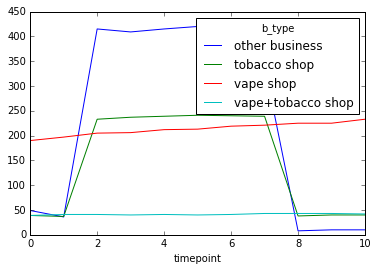

In [26]:

b_byTimepoint = unique_time[['yelp_id', 'b_type', 'timepoint']].groupby(['timepoint','b_type']).agg(['count'])
print(b_byTimepoint)

xtab = pd.crosstab(unique_time.timepoint, unique_time.b_type)

%matplotlib inline
xtab.plot()


There are a lot of false-positives of "tobacco shop" and "other business" listings. It also looks like Yelp may have changed their search algorithm over this time period, or something else happened because these false-positives are primarily in timepoints 2-7. Let's examine results by search term...

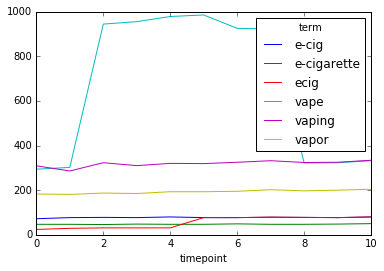

In [27]:
xtab = pd.crosstab(df.timepoint, df.term)

%matplotlib inline
xtab.plot()

It appears that the search results for "vape" may be the culprit for inflating the number of false positives over this time period. Let's check on that further in timepoint 2, where it began...

b_type       other business  tobacco shop  vape shop  vape+tobacco shop
term                                                                   
e-cig                     3            16         53                  6
e-cigarette               1             7         29                  9
ecig                      2             2         24                  3
vape                    413           255        230                 46
vaping                   25            21        231                 46
vapor                    19            16        133                 19


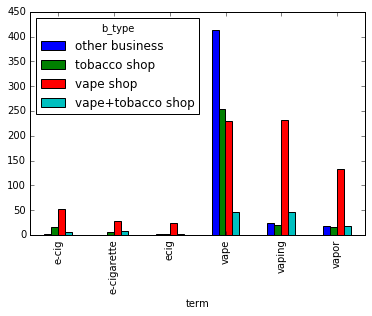

In [28]:
# Create a mask for timepoint #2
tp2_mask = df['timepoint'] == 2

# New dataframe with the mask
df2 = df[tp2_mask]

# Cross-tabulate the new dataframe by search term and business type
xtab2 = pd.crosstab(df2.term, df2.b_type)
print(xtab2)
xtab2.plot(kind='bar')

Because the "vape" search term seems to be problematic, I want to examine the results by "vape" versus all other search terms.

b_type    other business  tobacco shop  vape shop  vape+tobacco shop
vapeterm                                                            
False                 50            62        470                 83
True                 413           255        230                 46


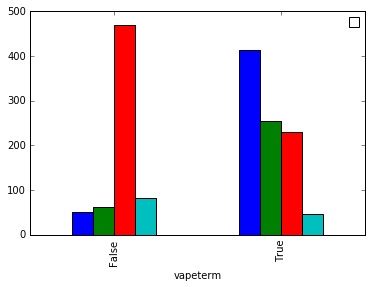

In [29]:
df['vapeterm'] = df['term']=='vape'

tp2_mask = df['timepoint'] == 2

df2 = df[tp2_mask]

xtab2 = pd.crosstab(df2.vapeterm, df2.b_type)
print(xtab2)
ax = xtab2.plot(kind='bar')

ax.legend('') # I hid the legend here because it obscured the bars. 

This data dive has been interesting, but falling down the rabbit hole is getting beyond the scope of this assignment (sorry). I'll dig back into this work later on. 
__Notes to self:__
* The "vape" search drew many more false positives than true positives for identifying vape shops across some timepoints.
* I might want to figure out how many true positives the "vape" search caught, that weren't caught by other search strategies. 
* In the larger scope of things, this may not matter, as the spike in false positives disappeared after timepoint \#7.

### Wrapping up:
__What I accomplished:__
* Read data files for multiple timepoints and ignored ancillary non-data files
* Overcame frustrating data encoding issues (`utf-8` to `latin-1`)
* Sorted and iterated over data files to define a timepoint variable
* Recoded messy address data to determine what state the business listing was in
* Recoded "business type" data to identify vape shops, tobacco shops, and other businesses (false positives)
* Examined false positives across various search terms, per business type, over time
* Cross-tabulated and graphed some data trends to make sense of it all
* Realized that I was digging down a rabbit hole
* Stopped digging, and provided a summary of workable code (below)



In [30]:
import os, csv

dir_in = '//home/jason/repos/YelpEpi/' # This is my local directory
files = sorted(os.listdir(data_dir)) # Use sorted() to list files in ascending order

# Function to parse state abbreviation from address
def getState(address):
    if len(address.split('|')[-1].split(' ')[-1]) == 2: # Is the last position a 2-character string?
        state = address.split('|')[-1].split(' ')[-1] # If so, use that
    else:
        state = address.split('|')[-1].split(' ')[-2] # Otherwise, use the second-to-last position
    return state

# Function to parse business type from Yelp categories 
def businessType(tag):
    if 'vapeshops' in tag:
        b_type = 'vape shop' # get anything clasified as a vape shop
    else:
        b_type = 'other'
    return b_type
    
# Function to write the output file with only the columns that we're interested in
def writeLine(timepoint, l, state, b_type, mode):
    v = l.split(',')    
    with open(data_dir+'output.csv', mode) as output: # 'mode' to select 'w+' (clean file w/ header) or 'a' (append data)
        CSVwriter = csv.writer(output, delimiter=',')
        CSVwriter.writerow([timepoint, v[1], v[5], v[6], v[7], v[10], 
                            v[11], v[12], v[13], v[14], v[15], v[16], 
                            v[17], v[18], state, b_type])

# No more functions - all processing from here on out...

# Iterate through data files and output data to a consolidated file
timepoint = 0 # Set the initial timepoint to zero
for f in files:
    if '.csv' in f[-4:] and 'output' not in f: # Only include CSV files (and not the output file)
        line = 0 # Need to iterate lines to control for header rows in data files
        with open(data_dir+f, encoding='latin-1') as file:
            for l in file: # The 'l' variable is a comma-delimited string of data
                if timepoint == 0 and line == 0:
                    writeLine('timepoint', l, 'state', 'b_type', mode = 'w+') # Write initial header row to new/blank output file
                elif line > 0:
                    b_type = businessType(l.split(',')[18]) # Business type data in comma-delimited position #18
                    state = getState(l.split(',')[16]) # Address data in comma-delimited position #16
                    writeLine(timepoint, l, state, b_type, mode = 'a') # Append the data row to the output file
                else:
                    pass
                line = line + 1 # Iterate lines within each data file
            timepoint = timepoint + 1 # Iterate timepoint for each data file that is read

# Read the combined data file as a dataframe and use the correct encoding
df = pd.read_csv(data_dir+'output.csv', encoding='latin-1')

# Create a new dataframe with unique business listings
unique = df.drop_duplicates(['yelp_id'], keep='first')

# Create a mask for listings in PA
pa_mask = unique['state'] == 'PA'

# Create a mask for 'vape shop' business type
vape_mask = unique['b_type'] == 'vape shop'

# Filter a dataframe using the masks
cleaned = unique[pa_mask & vape_mask]

# These are the final results!
cleaned.info()
cleaned.head(3) # Only display the first 3 records



<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 14065
Data columns (total 16 columns):
timepoint          251 non-null int64
term               251 non-null object
location           251 non-null object
lat                251 non-null float64
lng                251 non-null float64
yelp_id            251 non-null object
is_closed          251 non-null bool
rating             251 non-null float64
review_count       251 non-null int64
name               251 non-null object
phone              250 non-null float64
display_address    251 non-null object
url                251 non-null object
yelpcats           251 non-null object
state              251 non-null object
b_type             251 non-null object
dtypes: bool(1), float64(4), int64(2), object(9)
memory usage: 22.8+ KB


,timepoint,term,location,lat,lng,yelp_id,is_closed,rating,review_count,name,phone,display_address,url,yelpcats,state,b_type
0,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549806,-75.491105,get-your-vape-on-emmaus,False,4.0,4,Get Your Vape On,6104218310,610 State Ave | Emmaus PA 18049,http://www.yelp.com/biz/get-your-vape-on-emmau...,vapeshops |,PA,vape shop
1,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.549495,-75.597692,vape-flow-trexlertown-2,False,4.5,2,Vape Flow,4846498347,7150 Hamilton Blvd | Trexlertown PA 18087,http://www.yelp.com/biz/vape-flow-trexlertown-...,vapeshops |,PA,vape shop
2,0,vape,Allentown-Bethlehem-Easton | PA-NJ Metro Area ...,40.629023,-75.477516,blue-monkey-vape-whitehall,False,1.0,1,Blue Monkey Vape,6102310555,250 Lehigh Valley Mall | Whitehall PA 18052,http://www.yelp.com/biz/blue-monkey-vape-white...,vapeshops |,PA,vape shop


Let's graph PA vape shops over the data collection timepoints...

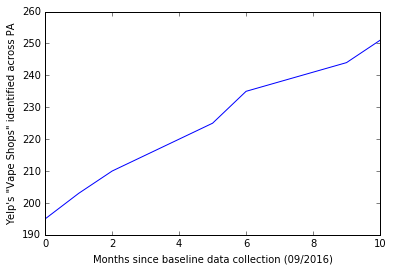

In [31]:
%matplotlib inline

xtab = pd.crosstab(cleaned.timepoint, cleaned.b_type)
#print(xtab)

#create an array of cumulative counts over timepoints
cum_sum = 0
cumulative = []
for freq in xtab['vape shop']:
    cum_sum = cum_sum + freq
    cumulative.append(cum_sum)

#print(cumulative)
ax = pd.Series(cumulative).plot(kind='line')
ax.set_xlabel('Months since baseline data collection (09/2016)')
ax.set_ylabel('Yelp\'s "Vape Shops" identified across PA')
#ax.set_title('Vape shops in PA over time')


_Note to self:_ Update the remote repository...

In [32]:
#!git add .
#!git commit -m "update files"
#!git config user.email "colditzjb@gmail.com"
#!git push origin master